In [1]:
# General imports
import copy
import numpy as np
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

In [4]:
# Define character sets
lowercase = 'abcdefghijklmnopqrstuvwxyz'
uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
digits = '0123456789'
special = '@#$%&'

# Combine all characters
all_chars = lowercase + uppercase + digits + special

# Generate password of length 29
password = ''.join(np.random.choice(list(all_chars), size=19))
print(f"Generated password: {password}")

Generated password: HRR9f70Dn6uv@IA4nxQ


# Variational ansatz with many paraneters

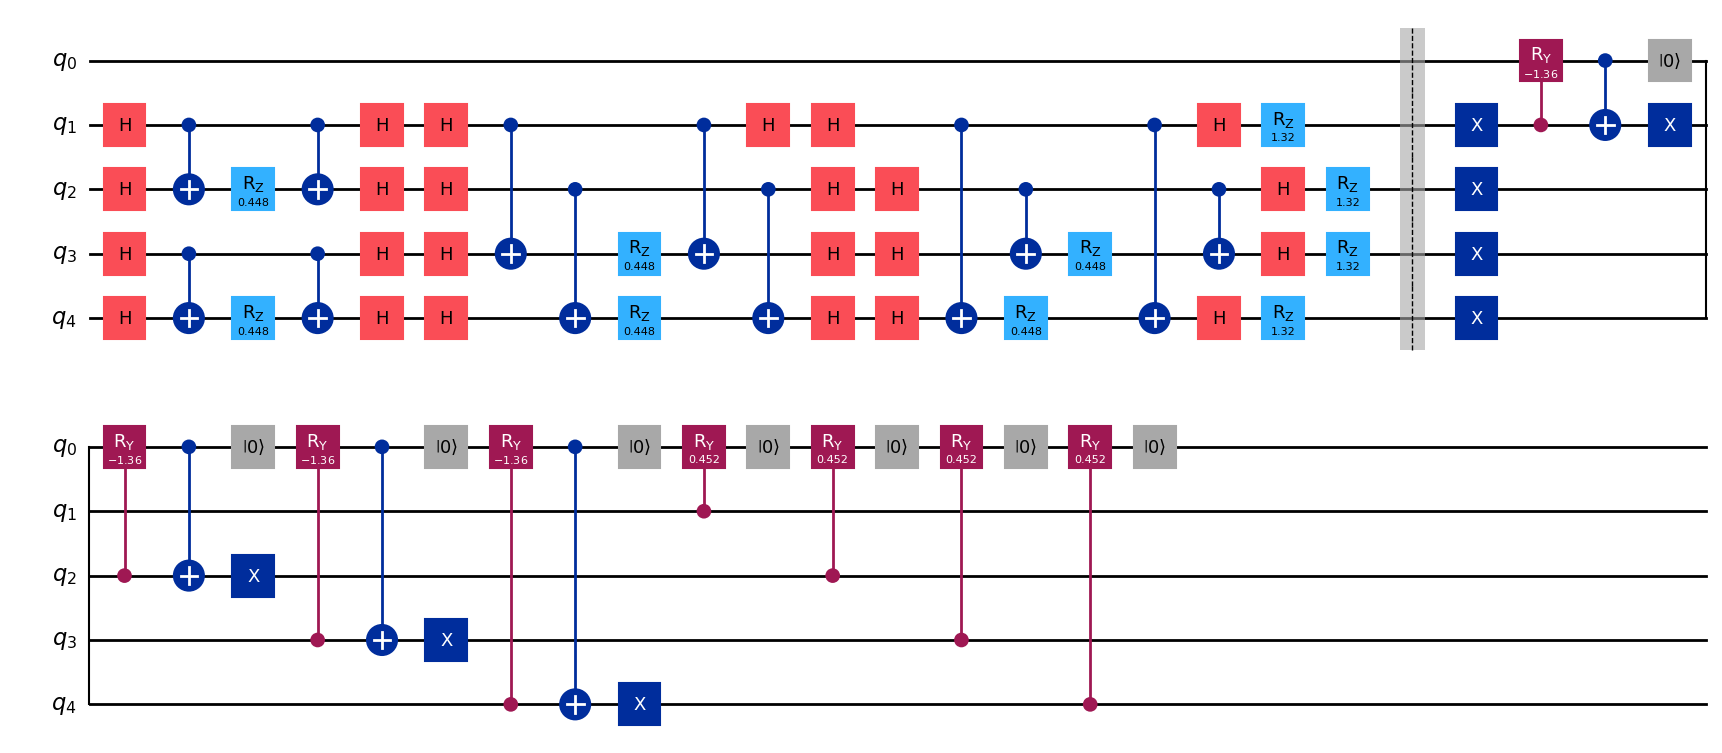

In [5]:
# VQA circuit.
from qiskit import QuantumCircuit

# Pauli matrices and identity (sparse format)
I = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

# The variational circuit is just the trotter circuit for the TFIM.
n_qubits = 4

# For parallelization of the circuit we will group the qubits.
def divide_pairs(pairs):
    sets = []  # List to hold the sets of pairs
    for pair in pairs:
        added = False
        for s in sets:
            # Check if the pair conflicts with any existing set
            if all(len(set(pair).intersection(set(existing_pair))) == 0 for existing_pair in s):
                s.append(pair)
                added = True
                break
        if not added:
            # If no compatible set found, create a new set
            sets.append([pair])
    return sets

hamiltonian_xx = [(i,j) for i in range(1, n_qubits +1 ) for j in range(i+1, n_qubits + 1)]
qubits_grouped = divide_pairs(hamiltonian_xx)

def variational_circuit(angles_lst, number_of_layers):  

    anstaz_circuit = QuantumCircuit(n_qubits + 1)

    for l in range(number_of_layers):

        # Translational invariance.
        XX_angle = angles_lst[l][0]
        Z_angle = angles_lst[l][1]
        L1_angle = angles_lst[l][2]
        L2_angle = angles_lst[l][3]

        for qubit_set in qubits_grouped:
            for qubit in qubit_set:
                anstaz_circuit.h(qubit[0])
                anstaz_circuit.h(qubit[1])
                anstaz_circuit.cx(qubit[0], qubit[1])
                anstaz_circuit.rz(XX_angle, qubit[1])
                anstaz_circuit.cx(qubit[0], qubit[1])
                anstaz_circuit.h(qubit[0])
                anstaz_circuit.h(qubit[1])

        for q in range(n_qubits):
            anstaz_circuit.rz(Z_angle, q + 1)

        anstaz_circuit.barrier()
        for q in range(1, n_qubits + 1):
            anstaz_circuit.x(q)
            anstaz_circuit.cry(L1_angle, q, 0)
            anstaz_circuit.cx(0,q)
            anstaz_circuit.x(q)
            anstaz_circuit.reset(0)     

        for q in range(1, n_qubits + 1):
            anstaz_circuit.cry(L2_angle, q, 0)
            anstaz_circuit.reset(0)                 
    # Transpile the circuit for optimization.
    #anstaz_circuit = qiskit.transpile(anstaz_circuit, basis_gates = ["rz", "h", "cx", "ry", "x"], optimization_level = 3)

    return anstaz_circuit   

number_of_parameters_per_layer = 4
number_of_layers = 1

initial_angles = [[np.random.uniform(-np.pi, np.pi) for _ in range(number_of_parameters_per_layer)] for _ in range(number_of_layers)]

variational_circuit(initial_angles, number_of_layers).draw("mpl", scale = 1)  

# Variational ansatz

In [6]:
# n_qubits = 2

# # Generate all pairs (i, j) for the XX term with periodic boundary conditions
# hamiltonian_xx = [(i, j) for i in range(1, n_qubits + 1) for j in range(i + 1, n_qubits + 1)]

# # Add periodic boundary condition: interaction between the last qubit and the first qubit
# hamiltonian_xx.append((n_qubits, 1))  # Adding the last-to-first qubit interaction

# pauli_strings = []
# for pos in hamiltonian_xx:
#     pauli = ['I'] * n_qubits  # Start with all 'I'
#     for p in pos:
#         pauli[p - 1] = 'X'  # Set 'X' at the given positions (1-indexed to 0-indexed)
#     pauli_strings.append(''.join(pauli))

# def variational_circuit(angles_lst, number_of_layers):

#     # Create a quantum circuit with n_qubits + 1 qubits
#     circuit = QuantumCircuit(n_qubits + 1)

#     for l in range(number_of_layers):

#         # Translational invariance.
#         XX_angle = angles_lst[l][0]
#         Z_angle = angles_lst[l][1]
#         L1_angle = angles_lst[l][2]
#         L2_angle = angles_lst[l][3]

#         # Coefficients for each term (set to 1 for simplicity)
#         coefficients = [XX_angle] * len(pauli_strings)

#         # Create the SparsePauliOp
#         sparse_pauli_op = SparsePauliOp(pauli_strings, coeffs=coefficients)

#         # Create a Pauli evolution gate for the Hamiltonian
#         evolution_gate = PauliEvolutionGate(sparse_pauli_op, time=1.0)

#         # Add the Pauli evolution gate to the circuit from qubit 1 to n_qubits+1
#         circuit.append(evolution_gate, range(1, n_qubits + 1))

#         # Z terms.
#         for q in range(1, n_qubits + 1):
#             circuit.rz(Z_angle, q)

#         # Lindblad terms.
#         for q in range(1, n_qubits + 1):
#             circuit.x(q)
#             circuit.cry(L1_angle, q, 0)
#             circuit.cx(0, q)
#             circuit.x(q)
#             circuit.reset(0)

#         for q in range(1, n_qubits + 1):
#             circuit.cry(L2_angle, q, 0)
#             circuit.reset(0)

#     return circuit

# number_of_parameters_per_layer = 4
# number_of_layers = 1

# initial_angles = [[np.random.uniform(-np.pi, np.pi) for _ in range(number_of_parameters_per_layer)] for _ in range(number_of_layers)]

# variational_circuit(initial_angles, number_of_layers).draw("mpl", scale = 1)     

# Noise model

In [7]:
L = n_qubits
from qiskit_aer.noise import (
    NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error,
)
"""
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05
 
# QuantumError objects
error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
error_meas = pauli_error([("X",p_meas), ("I", 1 - p_meas)])
error_gate1 = pauli_error([("X",p_gate1), ("I", 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
 
# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

noise_model = noise_bit_flip
 
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
"""

# T1 and T2 values for qubits 0-3
T1s = np.random.normal(1500e4, 1e4, L+1)  # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(1000e4, 1e4, L+1)  # Sampled from normal distribution mean 50 microsec
 
# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(L+1)])
 
# Instruction times (in nanoseconds)
time_u1 = 0  # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100  # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000  # 1 microsecond
 
# QuantumError objects
errors_reset = [
    thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)
]
errors_measure = [
    thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)
]
errors_u1 = [
    thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)
]
errors_u2 = [
    thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)
]
errors_u3 = [
    thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)
]
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(
            thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]
 
# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(L+1):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(L+1):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
 
noise_model = noise_thermal
print(noise_model)
from qiskit import transpile

def return_density_matrix(quantum_circuit):

    quantum_circuit.save_density_matrix()  # Save the density matrix

    # Step 2: Simulate the circuit
    simulator = AerSimulator(noise_model=noise_thermal)  # Aer simulator supports reset gates
    #simulator = AerSimulator()  # Aer simulator supports reset gates
    quantum_circuit = transpile(quantum_circuit, simulator)
    result = simulator.run(quantum_circuit).result()
    # Step 3: Extract the density matrix
    rho_full = DensityMatrix(result.data()["density_matrix"])

    # Step 4: Compute the reduced density matrix for the second qubit
    rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
    rho_1_matrix = rho_1.data

    return rho_1_matrix

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u3', 'reset', 'measure', 'u2', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 4)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (2, 4)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3)), ('cx', (3, 4)), ('cx', (4, 0)), ('cx', (4, 1)), ('cx', (4, 2)), ('cx', (4, 3)), ('cx', (4, 4))]


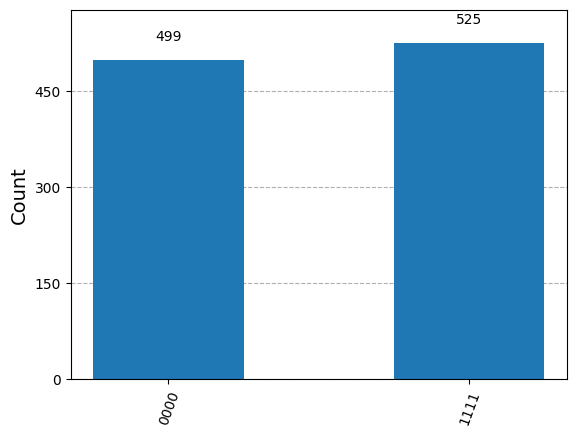

In [8]:
from qiskit.visualization import plot_histogram
# Create a simple GHZ circuit
ghz_circuit = QuantumCircuit(n_qubits)
ghz_circuit.h(0)
for i in range(n_qubits - 1):
     ghz_circuit.cx(i, i + 1)
ghz_circuit.measure_all()

# Transpile the circuit for the AerSimulator
transpiled_ghz_circuit = transpile(ghz_circuit, AerSimulator())

# Run the circuit on the AerSimulator with the noise model
simulator = AerSimulator(noise_model=noise_model)
result = simulator.run(transpiled_ghz_circuit).result()

# Get the counts and plot the histogram
counts = result.get_counts()
plot_histogram(counts)

# Lindblad equation

In [9]:
# Pauli matrices and identity (sparse format)
I2 = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

n = n_qubits
# Constants
J_total = 1
Delta = 0.5
gamma = 0.5
gamma_e = gamma
gamma_d = gamma

def build_hamiltonian(n):
    """Construct the Hamiltonian for the infinite-ranged Ising model."""
    H = csr_matrix((2**n, 2**n), dtype=complex)

    J_0 = J_total / (n-1)
    # Infinite ranged XX term
    for i in range(n-1):
        for j in range(i+1, n):
            X_ops = [I2] * n
            X_ops[i] = sigma_x
            X_ops[j] = sigma_x
            X_term = X_ops[0]
            for op in X_ops[1:]:
                X_term = kron(X_term, op)

            H += J_0 * X_term

    # Z field term
    for i in range(n):
        Z_ops = [I2] * n
        Z_ops[i] = sigma_z
        Z_term = Z_ops[0]
        for op in Z_ops[1:]:
            Z_term = kron(Z_term, op)

        H -= Delta * Z_term

    return H

H = build_hamiltonian(n)

lindblad_op_sigma_minus_lst = []
lindblad_op_sigma_z_lst = []

for i in range(n):
    # sigma+ operator
    sigma_plus_i = [I2] * n
    sigma_plus_i[i] = (sigma_x + 1j*sigma_y) / 2
    sigma_plus_i_op = sigma_plus_i[0]
    for op in sigma_plus_i[1:]:
        sigma_plus_i_op = kron(sigma_plus_i_op, op)

    # sigma- operator
    sigma_minus_i_op = sigma_plus_i_op.conj().T
    lindblad_op_sigma_minus_lst.append(sigma_minus_i_op)

    # sigma_z operator
    sigma_z_i = [I2] * n
    sigma_z_i[i] = sigma_z
    sigma_z_i_op = sigma_z_i[0]
    for op in sigma_z_i[1:]:
        sigma_z_i_op = kron(sigma_z_i_op, op)

    lindblad_op_sigma_z_lst.append(sigma_z_i_op)

def lindblad_equation(rho):
    
    rho = csr_matrix(rho)
    # Hamiltonian contribution
    H_comm = -1j * (H @ rho - rho @ H)

    lindblad_diss_term = csr_matrix((2**n, 2**n), dtype=complex)

    for i in range(n):

        sigma_minus_i_op = lindblad_op_sigma_minus_lst[i]
        sigma_z_i_op = lindblad_op_sigma_z_lst[i]

        lindblad_diss_term += gamma_e/2 * (sigma_minus_i_op.conj().T @ sigma_minus_i_op @ rho + rho @ sigma_minus_i_op.conj().T @ sigma_minus_i_op - 2 * sigma_minus_i_op @ rho @ sigma_minus_i_op.conj().T)
        lindblad_diss_term += gamma_d/4 * (rho - sigma_z_i_op @ rho @ sigma_z_i_op)

    return H_comm - lindblad_diss_term

# Cost function
def cost_function(rho):
    L_rho = lindblad_equation(rho)
    return np.real((L_rho.conj().T @ L_rho).diagonal().sum())

# Gradient descent and parameter shift rule

In [10]:
def update_angles(current_angles_lst, number_of_layers, number_of_parameters_per_layer, learning_rate):
    """
    Perform parameter-shift updates on angles for a VQA circuit.

    Parameters:
        current_angles_lst (array): Current angles for each layer (shape: [number_of_layers, number_of_parameters_per_layer]).
        number_of_layers (int): Number of layers in the VQA circuit.
        number_of_parameters_per_layer (int): Number of parameters per layer.
        learning_rate (float): Learning rate for gradient descent.

    Returns:
        updated_angles (array): Updated angles after applying parameter-shift rule.
    """
    # Initialize updated angles
    updated_angles = np.copy(current_angles_lst)
    
    circuits_plus_lst = []
    circuits_minus_lst = []

    rho_plus_lst = []
    rho_minus_lst = []

    # Iterate over each layer and each parameter
    for i in range(number_of_layers):
        for j in range(number_of_parameters_per_layer):
            # Create shifted angles for parameter (i, j)
            angles_plus = np.copy(current_angles_lst)
            angles_minus = np.copy(current_angles_lst)
            
            # Apply shifts
            angles_plus[i][j] += np.pi / 2
            angles_minus[i][j] -= np.pi / 2
            print("angle index: ", j)
            print("angle plus: ", angles_plus)
            print("angle minus: ", angles_minus)

            # Compute costs for shifted angles
            circuit_plus = variational_circuit(angles_plus, number_of_layers)
            circuit_minus = variational_circuit(angles_minus, number_of_layers)

            rho_plus = return_density_matrix(circuit_plus)
            rho_minus = return_density_matrix(circuit_minus)

            cost_plus = cost_function(rho_plus)
            cost_minus = cost_function(rho_minus)
            
            circuits_plus_lst.append(circuit_plus)
            circuits_minus_lst.append(circuit_minus)

            rho_plus_lst.append(rho_plus)
            rho_minus_lst.append(rho_minus)

            print("cost plus: ", cost_plus)
            print("cost minus: ", cost_minus)
            
            # Calculate gradient and update angle
            gradient = (cost_plus - cost_minus) / 2
            # print("Gradient for angle : ", j, "=", gradient)
            updated_angles[i][j] -= learning_rate * gradient
    
    return updated_angles, circuits_plus_lst, circuits_minus_lst, rho_plus_lst, rho_minus_lst

# Training

## Gradient descent

In [11]:
# #from qiskit import transpile

# # Parameters
# initial_learning_rate = 0.9
# decay_rate = 1.0
# number_of_layers = 1
# max_iterations = 5
# tolerance_for_convergence = 1e-4
# number_of_parameters_per_layer = 4
# # We will initialize the initial angles as the trotter angles.
# trotter_step = 0.2
# J = 1/(n_qubits-1)
# Delta = Delta
# initial_angles_lst = [[-J * trotter_step * 2, -Delta * trotter_step * 2, np.sqrt(trotter_step * gamma), np.sqrt(trotter_step * gamma) ] for _ in range(number_of_layers)]

# # initial_angles_lst = [[np.random.uniform(-np.pi, np.pi) for _ in range(number_of_parameters_per_layer)] for _ in range(number_of_layers)]

# angles_lst = copy.deepcopy(initial_angles_lst)
# best_angles_lst = copy.deepcopy(initial_angles_lst)

# # Initialize optimization variables
# number_of_iteration = 0
# best_cost = float("inf")
# best_iteration = 0
# cost_function_values_lst = []
# rho_lst = []
# circuits_lst = []

# # Optimization loop
# while number_of_iteration < max_iterations:
#     print("Current angles: ", angles_lst)
#     # Generate variational circuit and compute cost
#     vqa_circuit = variational_circuit(angles_lst, number_of_layers)
#     circuits_lst.append(vqa_circuit)
#     rho = return_density_matrix(vqa_circuit)
#     rho_lst.append(rho)
#     cost_value = cost_function(rho)

#     # Record and display the cost
#     cost_function_values_lst.append(cost_value)
#     print(f"Iteration {number_of_iteration}: Cost value = {cost_value:.6f}")

#     # Update best solution
#     if cost_value < best_cost:
#         best_cost = cost_value
#         best_angles_lst = angles_lst.copy()
#         best_iteration = number_of_iteration

#     # Check for convergence
#     if number_of_iteration > 0 and abs(cost_function_values_lst[-1] - cost_function_values_lst[-2]) < tolerance_for_convergence:
#         print("Optimization has converged.")
#         print(f"Best cost value: {best_cost:.6f}")
#         print("Best angles:", best_angles_lst)
#         break

#     # Adjust learning rate
#     learning_rate = initial_learning_rate / (1 + decay_rate * number_of_iteration)

#     # Update angles using the parameter-shift rule
#     angles_lst = update_angles(angles_lst, number_of_layers, number_of_parameters_per_layer, learning_rate)[0]

#     # Increment iteration counter
#     number_of_iteration += 1

# # Post-optimization summary
# if number_of_iteration == max_iterations:
#     print("The optimization did not converge within the maximum iterations.")
# print(f"Best cost value: {best_cost:.6f}")
# print("Best angles:", best_angles_lst)

In [12]:
# _, circuit_plus_lst, circuit_minus_lst, rho_plus_lst, rho_minus_lst = update_angles(initial_angles_lst, number_of_layers, number_of_parameters_per_layer, initial_learning_rate)

In [13]:
# circuit_plus_lst[0].draw("mpl", scale = 1)

## Adam optimizer

In [53]:
def adam_optimizer(angles_lst, number_of_layers, number_of_parameters_per_layer, 
                   cost_function, max_iterations=20, tolerance_for_convergence=1e-4, 
                   initial_learning_rate=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8):
     """
     Adam optimizer for variational quantum algorithms.

     Parameters:
          angles_lst (list): Initial angles for the variational circuit.
          number_of_layers (int): Number of layers in the circuit.
          number_of_parameters_per_layer (int): Number of parameters per layer.
          cost_function (callable): Function to compute the cost given the variational circuit's density matrix.
          max_iterations (int): Maximum number of iterations for optimization.
          tolerance_for_convergence (float): Tolerance for convergence based on cost function change.
          initial_learning_rate (float): Initial learning rate.
          beta1 (float): Exponential decay rate for the first moment estimates.
          beta2 (float): Exponential decay rate for the second moment estimates.
          epsilon (float): Small value to prevent division by zero.

     Returns:
          dict: Contains optimized angles, cost values, and iteration details.
     """
     # Initialize Adam parameters
     m = [[0.0] * number_of_parameters_per_layer for _ in range(number_of_layers)]  # First moment vector
     v = [[0.0] * number_of_parameters_per_layer for _ in range(number_of_layers)]  # Second moment vector
     t = 0  # Time step

     best_cost = float("inf")
     best_angles_lst = None
     cost_function_values_lst = []
     rho_lst = []

     for iteration in range(max_iterations):
          t += 1
          # Generate variational circuit and compute cost
          vqa_circuit = variational_circuit(angles_lst, number_of_layers)
          rho = return_density_matrix(vqa_circuit)
          rho_lst.append(rho)
          cost_value = cost_function(rho)
          cost_function_values_lst.append(cost_value)
          
          print(f"Iteration {iteration}: Cost value = {cost_value:.6f}")
          
          # Update best solution
          if cost_value < best_cost:
               best_cost = cost_value
               best_angles_lst = angles_lst.copy()

          # Check for convergence
          if iteration > 0 and abs(cost_function_values_lst[-1] - cost_function_values_lst[-2]) < tolerance_for_convergence:
               print("Optimization has converged.")
               break

          # Compute gradients using parameter-shift rule
          gradients = compute_gradients(angles_lst, number_of_layers, number_of_parameters_per_layer)

          # Update parameters with Adam
          for l in range(number_of_layers):
               for p in range(number_of_parameters_per_layer):
                    # Update biased first moment estimate
                    m[l][p] = beta1 * m[l][p] + (1 - beta1) * gradients[l][p]
                    # Update biased second raw moment estimate
                    v[l][p] = beta2 * v[l][p] + (1 - beta2) * (gradients[l][p] ** 2)
                    # Compute bias-corrected first and second moment estimates
                    m_hat = m[l][p] / (1 - beta1**t)
                    v_hat = v[l][p] / (1 - beta2**t)
                    # Update parameter
                    angles_lst[l][p] -= initial_learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
          print(angles_lst)

     return {
     "optimized_angles": best_angles_lst,
     "best_cost": best_cost,
     "cost_function_values": cost_function_values_lst,
     "rho_lst": rho_lst,
     "iterations": t
     }

def compute_gradients(angles_lst, number_of_layers, number_of_parameters_per_layer):
     """
     Compute gradients using the parameter-shift rule.

     Parameters:
          angles_lst (list): Current angles for the variational circuit.
          number_of_layers (int): Number of layers in the circuit.
          number_of_parameters_per_layer (int): Number of parameters per layer.

     Returns:
          list: Gradients for each parameter.
     """
     gradients = [[0.0] * number_of_parameters_per_layer for _ in range(number_of_layers)]
     for l in range(number_of_layers):
          for p in range(number_of_parameters_per_layer):
               # Create shifted angle sets
               angles_plus = copy.deepcopy(angles_lst)
               angles_minus = copy.deepcopy(angles_lst)
               angles_plus[l][p] += np.pi / 2
               angles_minus[l][p] -= np.pi / 2

               # Compute the cost for shifted parameters
               vqa_circuit_plus = variational_circuit(angles_plus, number_of_layers)
               vqa_circuit_minus = variational_circuit(angles_minus, number_of_layers)
               rho_plus = return_density_matrix(vqa_circuit_plus)
               rho_minus = return_density_matrix(vqa_circuit_minus)

               cost_plus = cost_function(rho_plus)
               cost_minus = cost_function(rho_minus)

               # Compute the gradient
               gradients[l][p] = (cost_plus - cost_minus) / 2

     return gradients

number_of_layers = 4
max_iterations = 100
tolerance_for_convergence = 1e-4
number_of_parameters_per_layer = 4
# We will initialize the initial angles as the trotter angles.
trotter_step = 0.2
J = 1/(n_qubits-1)
Delta = Delta
initial_angles_lst = [[-J * trotter_step * 2, -Delta * trotter_step * 2, np.sqrt(trotter_step * gamma), np.sqrt(trotter_step * gamma) ] for _ in range(number_of_layers)]

# Run Adam optimizer
results = adam_optimizer(
     angles_lst=initial_angles_lst,
     number_of_layers=number_of_layers,
     number_of_parameters_per_layer=number_of_parameters_per_layer,
     cost_function=cost_function,
     max_iterations=max_iterations,
     tolerance_for_convergence=1e-4,
     initial_learning_rate=0.001,
)

# Display results
print("Optimized angles:", results["optimized_angles"])
print("Best cost value:", results["best_cost"])

Iteration 0: Cost value = 5.344317
[[-0.13233333333960093, -0.20091938272796098, 0.31522776698048577, 0.3172277659432153], [-0.13433333208699275, -0.199070834052819, 0.31722776471695424, 0.3172277659896687], [-0.13433333332482394, -0.19903792437428733, 0.3172277658854561, 0.31722776599897634], [-0.13433333332444913, -0.19999999986677328, 0.31722776596051594, 0.31722776600175545]]
Iteration 1: Cost value = 5.331123
[[-0.13133333885513362, -0.20183892514180746, 0.3142264472051717, 0.3182273069714873], [-0.13528584320138493, -0.19814101621813904, 0.31822574155523886, 0.3182277103909046], [-0.13533342667372636, -0.19807559319736098, 0.31822774843628254, 0.31822780981040866], [-0.1353334731188923, -0.19999999975691965, 0.31822791308645504, 0.31822782798922666]]
Iteration 2: Cost value = 5.317769
[[-0.13033335584576683, -0.20275866698821032, 0.3132229938167679, 0.3192260848410418], [-0.13623202016823813, -0.19721041512765045, 0.31922016464402436, 0.31922755547763515], [-0.1363336749907175, -

## Other optimizer

In [47]:
# def compute_gradients(angles_lst, number_of_layers, number_of_parameters_per_layer):
#      """
#      Compute gradients using the parameter-shift rule.

#      Parameters:
#           angles_lst (list): Current angles for the variational circuit.
#           number_of_layers (int): Number of layers in the circuit.
#           number_of_parameters_per_layer (int): Number of parameters per layer.

#      Returns:
#           list: Gradients for each parameter.
#      """
#      gradients = [[0.0] * number_of_parameters_per_layer for _ in range(number_of_layers)]
#      for l in range(number_of_layers):
#           for p in range(number_of_parameters_per_layer):
#                # Create shifted angle sets
#                angles_plus = copy.deepcopy(angles_lst)
#                angles_minus = copy.deepcopy(angles_lst)
#                angles_plus[l][p] += np.pi / 2
#                angles_minus[l][p] -= np.pi / 2

#                # Compute the cost for shifted parameters
#                vqa_circuit_plus = variational_circuit(angles_plus, number_of_layers)
#                vqa_circuit_minus = variational_circuit(angles_minus, number_of_layers)
#                rho_plus = return_density_matrix(vqa_circuit_plus)
#                rho_minus = return_density_matrix(vqa_circuit_minus)

#                cost_plus = cost_function(rho_plus)
#                cost_minus = cost_function(rho_minus)

#                # Compute the gradient
#                gradients[l][p] = (cost_plus - cost_minus) / 2

#      return gradients

# def gradient_descent_optimizer(angles_lst, number_of_layers, number_of_parameters_per_layer, 
#                             learning_rate, cost_function,
#                             max_iterations=100, 
#                             tolerance_for_convergence=1e-4):
#     """
#     Gradient Descent optimizer for variational quantum algorithms.
#     """
#     rho_lst = []
#     cost_function_values_lst = []
#     best_angles_lst = copy.deepcopy(angles_lst)
#     best_cost = float('inf')

#     for iteration in range(max_iterations):
#         # Generate variational circuit and compute cost
#         print(angles_lst)
#         vqa_circuit = variational_circuit(angles_lst, number_of_layers)
#         rho = return_density_matrix(vqa_circuit)
#         rho_lst.append(rho)
#         cost_value = cost_function(rho)
#         cost_function_values_lst.append(cost_value)

#         print(f"Iteration {iteration}: Cost = {cost_value:.6f}")

#         # Update the best cost and parameters
#         if cost_value < best_cost:
#             best_cost = cost_value
#             best_angles_lst = copy.deepcopy(angles_lst)

#         # Check for convergence
#         if iteration > 0 and abs(cost_function_values_lst[-1] - cost_function_values_lst[-2]) < tolerance_for_convergence:
#             print("Converged.")
#             break

#         # Compute gradients using parameter-shift rule
#         gradients = compute_gradients(angles_lst, number_of_layers, number_of_parameters_per_layer)

#         # Update parameters using gradient descent
#         for l in range(number_of_layers):
#             for p in range(number_of_parameters_per_layer):
#                 angles_lst[l][p] -= learning_rate * gradients[l][p]

#     return {
#         'rho_lst': rho_lst,
#         "optimized_angles": best_angles_lst,
#         "best_cost": best_cost,
#         "cost_function_values": cost_function_values_lst,
#     }

# def momentum_optimizer(angles_lst, number_of_layers, number_of_parameters_per_layer, 
#                        cost_function, max_iterations=100, learning_rate=0.01, 
#                        momentum=0.9, tolerance_for_convergence=1e-4):
#     """
#     Momentum-based optimizer for variational quantum algorithms.
#     """
#     velocities = [[0.0] * number_of_parameters_per_layer for _ in range(number_of_layers)]
#     rho_lst = []
#     cost_function_values_lst = []
#     best_angles_lst = copy.deepcopy(angles_lst)
#     best_cost = float('inf')

#     for iteration in range(max_iterations):
#         # Generate variational circuit and compute cost
#         vqa_circuit = variational_circuit(angles_lst, number_of_layers)
#         rho = return_density_matrix(vqa_circuit)
#         rho_lst.append(rho)
#         cost_value = cost_function(rho)
#         cost_function_values_lst.append(cost_value)

#         print(f"Iteration {iteration}: Cost = {cost_value:.6f}")

#         # Update the best cost and parameters
#         if cost_value < best_cost:
#             best_cost = cost_value
#             best_angles_lst = copy.deepcopy(angles_lst)

#         # Check for convergence
#         if iteration > 0 and abs(cost_function_values_lst[-1] - cost_function_values_lst[-2]) < tolerance_for_convergence:
#             print("Converged.")
#             break

#         # Compute gradients using parameter-shift rule
#         gradients = compute_gradients(angles_lst, number_of_layers, number_of_parameters_per_layer)

#         # Update parameters using momentum
#         for l in range(number_of_layers):
#             for p in range(number_of_parameters_per_layer):
#                 velocities[l][p] = momentum * velocities[l][p] - learning_rate * gradients[l][p]
#                 angles_lst[l][p] += velocities[l][p]

#     return {'rho_lst': rho_lst,
#         "optimized_angles": best_angles_lst,
#         "best_cost": best_cost,
#         "cost_function_values": cost_function_values_lst,
#     }

# def nelder_mead_optimizer(initial_angles, cost_function, max_iterations=100, tolerance_for_convergence=1e-4):
#     """
#     Nelder-Mead optimizer for variational quantum algorithms.
#     """

#     def cost_fn_flat(flat_angles):
#         angles = np.reshape(flat_angles, initial_angles.shape)
#         vqa_circuit = variational_circuit(angles, number_of_layers)
#         rho = return_density_matrix(vqa_circuit)
#         return cost_function(rho)

#     from scipy.optimize import minimize

#     # Flatten the initial angles for optimization
#     initial_angles_flat = np.array(initial_angles).flatten()

#     result = minimize(
#         cost_fn_flat,
#         initial_angles_flat,
#         method="Nelder-Mead",
#         options={
#             "maxiter": max_iterations,
#             "fatol": tolerance_for_convergence
#         }
#     )

#     # Reshape the optimized angles back to original format
#     optimized_angles = np.reshape(result.x, initial_angles.shape)

#     return {
#         'rho_lst': rho_lst,
#         "optimized_angles": optimized_angles,
#         "best_cost": result.fun,
#         "iterations": result.nit,
#         "success": result.success,
#         "message": result.message,
#     }

# number_of_parameters_per_layer = 4
# number_of_layers = 4

# # Initialize angles
# trotter_step = 0.2
# J = 1 / (n_qubits - 1)
# initial_angles_lst = [[-J * trotter_step * 2, -Delta * trotter_step * 2, np.sqrt(trotter_step * gamma), np.sqrt(trotter_step * gamma) ] for _ in range(number_of_layers)]

# # # Random initial angles.
# # initial_angles_lst = [[np.random.uniform(-np.pi, np.pi) for _ in range(number_of_parameters_per_layer)] for _ in range(number_of_layers)]

# print("Initial angles:", initial_angles_lst)

# results = gradient_descent_optimizer(
#     angles_lst=initial_angles_lst,
#     number_of_layers=number_of_layers,
#     number_of_parameters_per_layer=number_of_parameters_per_layer,
#     learning_rate=0.001,
#     cost_function=cost_function,
#     max_iterations=100,
#     tolerance_for_convergence=1e-4,
# )

# # results = momentum_optimizer(initial_angles_lst, number_of_layers, number_of_parameters_per_layer, 
# #                        cost_function, max_iterations=100, learning_rate=0.05, 
# #                        momentum=0.9, tolerance_for_convergence=1e-4)

# # Display results
# print("Optimized angles:", results["optimized_angles"])
# print("Best cost value:", results["best_cost"])

Initial angles: [[-0.13333333333333333, -0.2, 0.31622776601683794, 0.31622776601683794], [-0.13333333333333333, -0.2, 0.31622776601683794, 0.31622776601683794], [-0.13333333333333333, -0.2, 0.31622776601683794, 0.31622776601683794], [-0.13333333333333333, -0.2, 0.31622776601683794, 0.31622776601683794]]
[[-0.13333333333333333, -0.2, 0.31622776601683794, 0.31622776601683794], [-0.13333333333333333, -0.2, 0.31622776601683794, 0.31622776601683794], [-0.13333333333333333, -0.2, 0.31622776601683794, 0.31622776601683794], [-0.13333333333333333, -0.2, 0.31622776601683794, 0.31622776601683794]]
Iteration 0: Cost = 5.344317
[[-0.13173782867867612, -0.2000000001140429, 0.31621738879162353, 0.3163635937368406], [-0.13334135681238096, -0.19999999986882497, 0.316235459002651, 0.31659582921680307], [-0.13450850510101928, -0.19999999974631735, 0.3163038800121599, 0.3167876260410262], [-0.13445892784789834, -0.2, 0.3164053165863839, 0.31689078606496357]]
Iteration 1: Cost = 5.340672
[[-0.1301343360790

# Analysis and plots

In [54]:
def FM_order(rho):
    # Initialize the spin correlation matrix
    spin_matrix = csr_matrix((rho.shape[0], rho.shape[0]), dtype=complex)
    
    for i in range(n):
        for j in range(n):
            # Create sigma_x operator for qubit i
            sigma_x_ij = [I2] * n
            sigma_x_ij[i] = sigma_x            
            # Create sigma_x operator for qubit j
            sigma_x_ij[j] = sigma_x
            sigma_x_ij_op = sigma_x_ij[0]
            for op in sigma_x_ij[1:]:
                sigma_x_ij_op = kron(sigma_x_ij_op, op)
                
            spin_matrix += sigma_x_ij_op

    # Calculate M_F using the trace formula
    mf = np.trace(spin_matrix @ rho) / n**2
    return mf.real  # Return the real part (expectation values are real)

In [55]:
cost_function_values_lst = results['cost_function_values']
# Find index of minimum cost
min_cost_index = cost_function_values_lst.index(min(cost_function_values_lst))

rho_lst = results['rho_lst']
best_rho = rho_lst[-1]

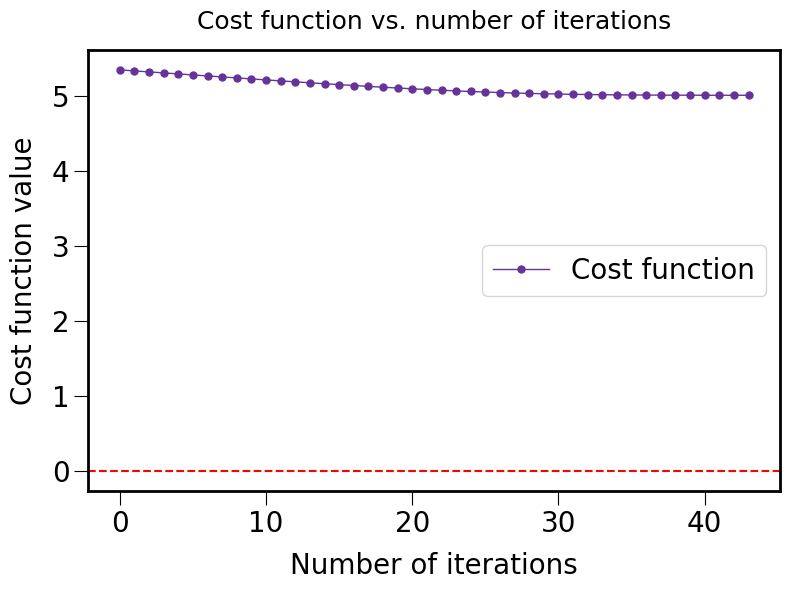

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(cost_function_values_lst)), cost_function_values_lst, marker="o", linestyle='-', color="rebeccapurple", linewidth=1, markersize=5, label="Cost function")
plt.xlabel("Number of iterations", fontsize=20, labelpad=10)
plt.ylabel("Cost function value", fontsize=20, labelpad=10)
plt.title("Cost function vs. number of iterations", fontsize=18, pad=15)
#plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color="r", linestyle="--")
# Get current axis
ax = plt.gca()
# Make axis lines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# Make ticks longer
ax.tick_params(axis='both', which='major', length=10)
plt.tight_layout()
#plt.axhline(y=0.8, color="r", linestyle="--")
plt.show()

FM parameter =  0.2505706941348892


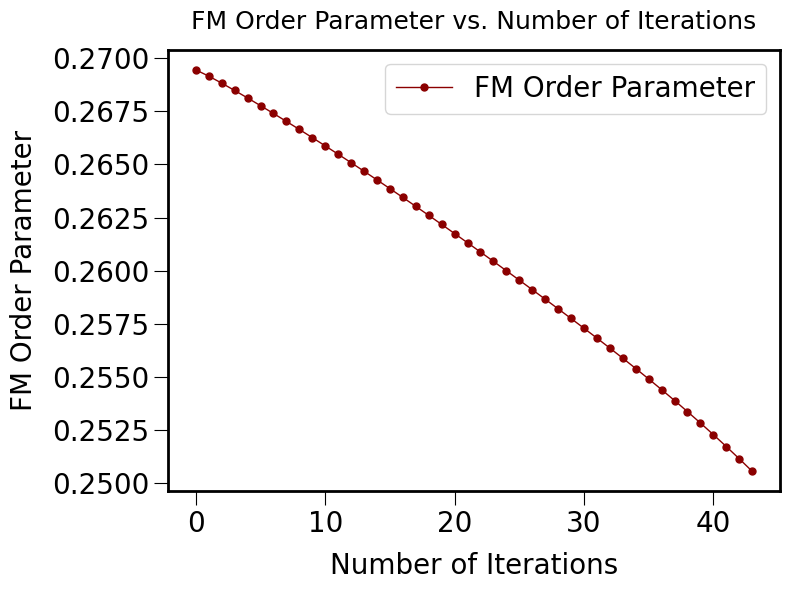

In [57]:
# Calculate FM order for each density matrix in rho_lst
fm_values = [FM_order(rho) for rho in rho_lst]
print("FM parameter = ", fm_values[-1])

# Create time points (one for each iteration)
time_points = range(len(fm_values))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(time_points, fm_values, marker="o", linestyle='-', color="darkred", 
           linewidth=1, markersize=5, label="FM Order Parameter")

plt.xlabel("Number of Iterations", fontsize=20, labelpad=10)
plt.ylabel("FM Order Parameter", fontsize=20, labelpad=10)
plt.title("FM Order Parameter vs. Number of Iterations", fontsize=18, pad=15)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Get current axis and customize appearance
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', length=10)
                                 
plt.tight_layout()
#plt.axhline(y=0.2, color="r", linestyle="--")
plt.show()

In [58]:
# # Create figure and primary y-axis
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plot cost function on primary y-axis
# color1 = 'rebeccapurple'
# ax1.plot(range(len(cost_function_values_lst)), cost_function_values_lst, 
#            marker="o", linestyle='-', color=color1, linewidth=2, markersize=8,
#            label="Cost Function")
# ax1.set_xlabel("Number of Iterations", fontsize=20, labelpad=10)
# ax1.set_ylabel("Cost Function Value", fontsize=20, labelpad=10, color=color1)
# ax1.tick_params(axis='y', labelcolor=color1)

# # Create secondary y-axis and plot FM parameter
# ax2 = ax1.twinx()
# color2 = 'darkred'
# ax2.plot(range(len(fm_values)), fm_values,
#            marker="s", linestyle='-', color=color2, linewidth=2, markersize=8,
#            label="FM Order Parameter")
# ax2.set_ylabel("FM Order Parameter", fontsize=20, labelpad=10, color=color2)
# ax2.tick_params(axis='y', labelcolor=color2)

# # Customize appearance
# ax1.tick_params(axis='both', which='major', labelsize=16, length=10)
# ax2.tick_params(axis='both', which='major', labelsize=16, length=10)

# # Add legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=16, loc='upper right')

# # Make spines thicker
# for ax in [ax1, ax2]:
#      ax.spines['top'].set_linewidth(2)
#      ax.spines['right'].set_linewidth(2)
#      ax.spines['bottom'].set_linewidth(2)
#      ax.spines['left'].set_linewidth(2)

# plt.title("Cost Function and FM Order vs. Iterations", fontsize=20, pad=15)
# plt.tight_layout()
# # ax1.axhline(y=0, color='r', linestyle='--')
# # ax2.axhline(y=0.0, color='g', linestyle='-.')
# plt.show()